In [1]:
import yfinance as yf
import cvxpy as cp
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS

%matplotlib notebook

register_matplotlib_converters()

In [2]:
def ComputeReturnAndVolatility(data):
    mean = np.mean(data)
    sigma = np.std(data)
    return mean, sigma

In [3]:
# 从 Yahoo Finance 下载历史数据

tickers = [
    'SPY',   # S&P500 ETF
    'NVDA',
    'DPZ'
]

data = yf.download(
    tickers = tickers,
    period = '4y',
    interval = '1d',
    group_by = 'ticker',
    auto_adjust = True,
    prepost = True).dropna()

[*********************100%***********************]  3 of 3 completed


In [4]:
data = data['2017-10-03':'2020-10-02']

sp500 = data['SPY']['Close'].to_numpy()
nvda = data['NVDA']['Close'].to_numpy()
dpz = data['DPZ']['Close'].to_numpy()

# Returns every 5 trading days, proxy of weekly return.
sp500_wk = sp500[::5]
nvda_wk = nvda[::5]
dpz_wk = dpz[::5]

sp500_wk_ret = sp500_wk[1:]/sp500_wk[:-1]
nvda_wk_ret = nvda_wk[1:]/nvda_wk[:-1]
dpz_wk_ret = dpz_wk[1:]/dpz_wk[:-1]

index_wk = data.index[::5]
index_wk = index_wk[1:]

assert(len(index_wk)==len(sp500_wk_ret))

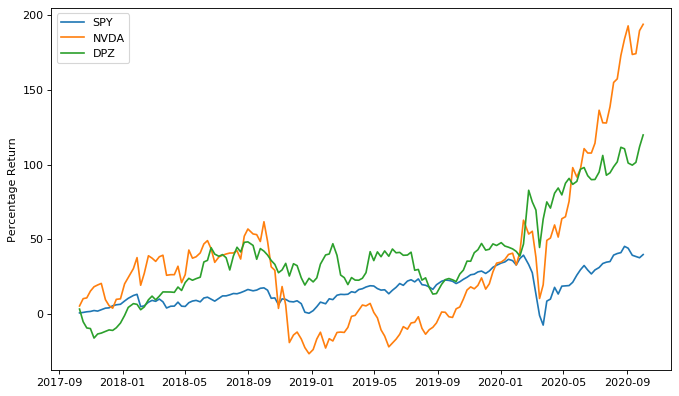

In [5]:
fig1 = plt.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k')
ax = fig1.add_subplot(1,1,1)
ax.plot(index_wk, np.cumprod(sp500_wk_ret)*100 - 100)
ax.plot(index_wk, np.cumprod(nvda_wk_ret)*100 - 100)
ax.plot(index_wk, np.cumprod(dpz_wk_ret)*100 - 100)
ax.set_ylabel('Percentage Return')

ax.legend(['SPY', 'NVDA', 'DPZ'])

SPY vs NVDA correlation coefficient:  0.6677977479032567
SPY vs NVDA beta:  1.5462007192725227
SPY vs DPZ correlation coefficient:  0.2614843829873183


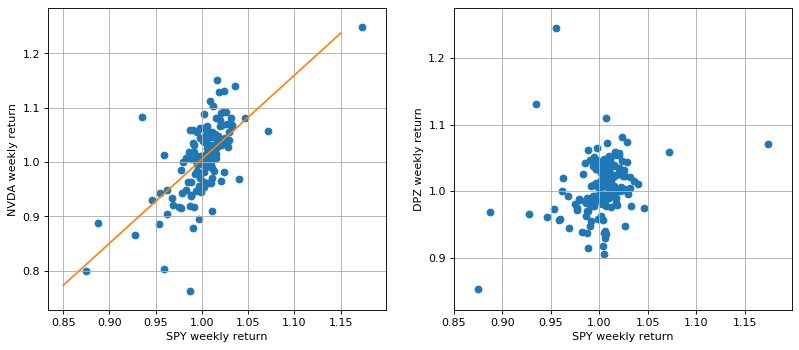

In [6]:
model = OLS(nvda_wk_ret, sm.add_constant(sp500_wk_ret)).fit()
alpha = model.params[0]
beta = model.params[1]

fit_line_x = np.linspace(0.85,1.15, 5)
fit_line_y = alpha + fit_line_x * beta


print('SPY vs NVDA correlation coefficient: ', np.corrcoef(sp500_wk_ret, nvda_wk_ret)[0][1])
print('SPY vs NVDA beta: ', beta)
print('SPY vs DPZ correlation coefficient: ', np.corrcoef(sp500_wk_ret, dpz_wk_ret)[0][1])

fig1 = plt.figure(figsize=(12, 5), dpi= 80, facecolor='w', edgecolor='k')
ax = fig1.add_subplot(1,2,1)
ax.scatter(sp500_wk_ret, nvda_wk_ret)
ax.plot(fit_line_x, fit_line_y, color='C1')
ax.set_xlabel('SPY weekly return')
ax.set_ylabel('NVDA weekly return')
ax.grid()

ax = fig1.add_subplot(1,2,2)
ax.scatter(sp500_wk_ret, dpz_wk_ret)
ax.set_xlabel('SPY weekly return')
ax.set_ylabel('DPZ weekly return')
ax.grid()

In [7]:
def ComputeEfficientFrontier(returns):
    
    num_of_assets = 2
    
    covmat = np.cov(returns)
    mu = np.mean(returns, axis=1)
    weights = cp.Variable(num_of_assets)
    objective = cp.Minimize(cp.quad_form(weights, covmat))
    
    mu_min = np.min(mu)
    mu_max = np.max(mu)
    
    targets = np.linspace(mu_min, mu_max, 20)
    
    means = []
    vols = []
    for t in targets:
        constraints = [np.ones(num_of_assets) @ weights == 1,
                       weights @ mu == t
                      ]
        problem = cp.Problem(objective, constraints)
        problem.solve()
        
        vols.append(np.sqrt(problem.value))
        means.append(t)
    
    return np.array(means), np.array(vols)

Weights:  [0.77685047 0.22314953]


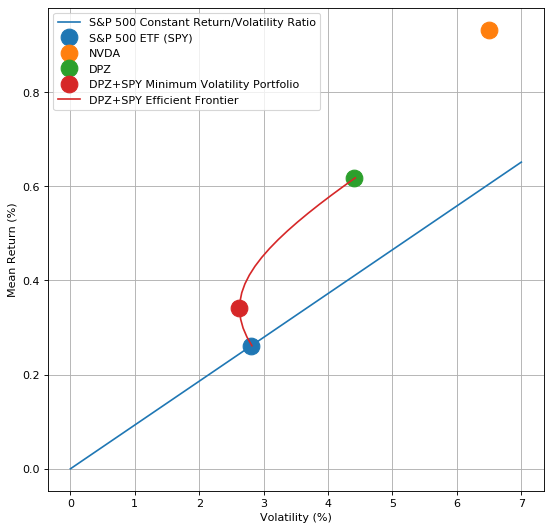

In [8]:

num_of_assets = 2

returns = np.array([sp500_wk_ret, dpz_wk_ret])
covmat = np.cov(returns)
mu = np.mean(returns, axis=1)

means, vols = ComputeEfficientFrontier(returns)

weights = cp.Variable(num_of_assets)
constraints = [np.ones(num_of_assets) @ weights == 1]
objective = cp.Minimize(cp.quad_form(weights, covmat))

problem = cp.Problem(objective, constraints)
problem.solve()

print('Weights: ', weights.value)
portfolio = np.sum(weights.value * returns.T, axis=1)

sp500_ret_mean, sp500_ret_sigma = ComputeReturnAndVolatility(sp500_wk_ret-1)
nvda_ret_mean, nvda_ret_sigma = ComputeReturnAndVolatility(nvda_wk_ret-1)
dpz_ret_mean, dpz_ret_sigma = ComputeReturnAndVolatility(dpz_wk_ret-1)
port_ret_mean, port_ret_sigma = ComputeReturnAndVolatility(portfolio-1)

sp500_line_x = np.linspace(0, 7, 5)
sp500_line_y = sp500_line_x * sp500_ret_mean / sp500_ret_sigma

fig1 = plt.figure(figsize=(8, 8), dpi= 80, facecolor='w', edgecolor='k')
ax = fig1.add_subplot(1,1,1)
ax.plot(sp500_line_x, sp500_line_y, color='C0')
ax.plot(sp500_ret_sigma * 100, sp500_ret_mean * 100, '.', color='C0', markersize=30)
ax.plot(nvda_ret_sigma * 100, nvda_ret_mean * 100, '.', color='C1', markersize=30)
ax.plot(dpz_ret_sigma * 100, dpz_ret_mean * 100, '.', color='C2', markersize=30)
ax.plot(port_ret_sigma * 100, port_ret_mean * 100, '.', color='C3', markersize=30)

ax.plot(vols*100, (means-1)*100, color='C3')

ax.legend(['S&P 500 Constant Return/Volatility Ratio', 
           'S&P 500 ETF (SPY)', 
           'NVDA',
           'DPZ',
           'DPZ+SPY Minimum Volatility Portfolio',
           'DPZ+SPY Efficient Frontier'])

ax.set_xlabel('Volatility (%)')
ax.set_ylabel('Mean Return (%)')
ax.grid()
plt.show()

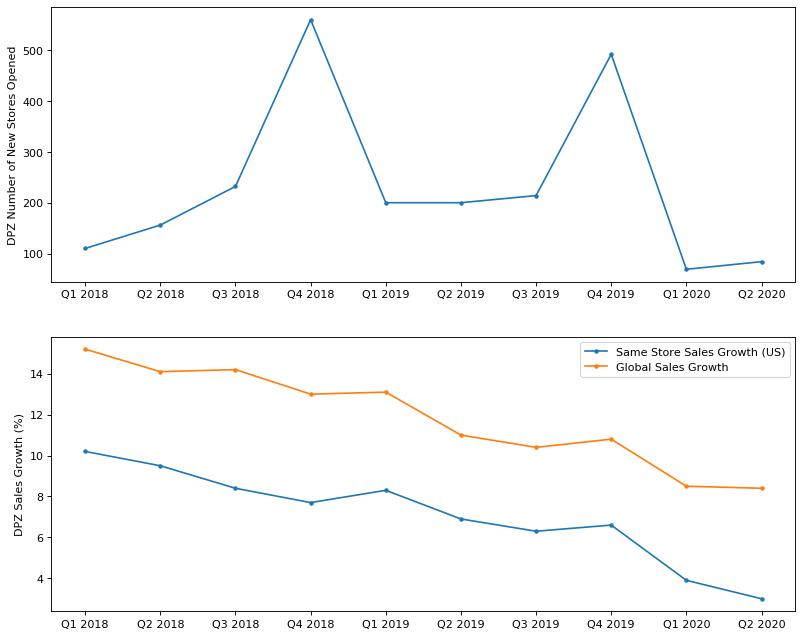

In [9]:
new_stores = [84,69,492,214,200,200,560,232,156,110]
same_store_growth = [3.00,3.90,6.60,6.30,6.90,8.30,7.70,8.40,9.50,10.20]
overall_growth = [8.40,8.50,10.80,10.40,11.00,13.10,13.00,14.20,14.10,15.20]
x = ['Q2 2020', 'Q1 2020', 'Q4 2019', 'Q3 2019', 'Q2 2019', 'Q1 2019', 'Q4 2018', 'Q3 2018', 'Q2 2018', 'Q1 2018']

new_stores.reverse()
same_store_growth.reverse()
overall_growth.reverse()
x.reverse()

fig1 = plt.figure(figsize=(12, 10), dpi= 80, facecolor='w', edgecolor='k')
ax = fig1.add_subplot(2,1,1)
ax.plot(x, new_stores, '.-')
ax.set_ylabel('DPZ Number of New Stores Opened')

ax = fig1.add_subplot(2,1,2)
ax.plot(x, same_store_growth, '.-')
ax.plot(x, overall_growth, '.-')
ax.legend(['Same Store Sales Growth (US)', 'Global Sales Growth'])
ax.set_ylabel('DPZ Sales Growth (%)')
plt.show()